In [1]:
colab = False

if colab:
  from google.colab import drive
  drive.mount('/content/gdrive')
  
  import os
  os.chdir('/content/gdrive/My Drive/02460AdvancedML/Code/')
  
  #!git clone https://github.com/rtqichen/torchdiffeq.git
  !pip install -e torchdiffeq

In [7]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.cluster import DBSCAN
import torch
import numpy as np
from scipy.io import loadmat
from land.curve import *
from land.geodesics import *
from land.local_pca_metric import *
import matplotlib.pyplot as plt
import seaborn as sns
import math
from mpl_toolkits.mplot3d import Axes3D
import torch
import numpy as np
from scipy.io import loadmat
from land.curve import *
from land.geodesics import *
from land.local_pca_metric import *
from IPython.display import Image
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import sys
from time import perf_counter
import multiprocessing
from functools import partial
from contextlib import contextmanager
import pickle
import os




#Read Data

In [8]:
def load_data(r=range(1),fp=""):
  
    C=[]
    Sigma=[]
    mu=[]
    respons =[]
    for i in r:
        print(i)
        C_temp = pickle.load( open( fp+"C_"+str(i), "rb" ) )
        C.append(C_temp)
        Sigma_temp = pickle.load( open( fp+"Sigma_"+str(i), "rb" ) )
        Sigma.append(Sigma_temp)
        mu_temp = pickle.load( open( fp+"mu_"+str(i), "rb" ) )
        mu.append(mu_temp)
        respons_temp = pickle.load( open( fp+"respons_"+str(i), "rb" ) )
        respons.append(respons_temp)
    return C,Sigma,mu,respons


In [9]:
file_path = "results_mm/N500/data_halfmoon.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
## read
bytes_in = bytearray(0)
input_size = os.path.getsize(file_path)
with open(file_path, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        bytes_in += f_in.read(max_bytes)
data = pickle.loads(bytes_in)

In [10]:
N,D=data.shape


In [11]:
## Parameters for metric
sigma = 0.05 #0.1
rho = 0.1 #0.1

In [12]:
## Create metric
M = LocalVarMetric(data=data, sigma=sigma, rho=rho)

In [13]:
def ExpMap(M,p,v):
    c = shooting_geodesic(M,p,v)[0]
    return c[-1].reshape(1, D)

In [14]:
def LogMap(p,q, num_nodes=10):
    C = CubicSpline(begin=p, end=q, num_nodes=num_nodes, requires_grad=True)
    geodesic_minimizing_energy(C, M)
    t = torch.linspace(0, 1, 2, dtype=C.begin.dtype)
    return C.deriv(t)[0].detach(),C

In [15]:
'''
Getting data for plotting ellipses
prec - precission factor of the plot
p - error factor
'''
def normal_LAND(mu_tensor, Sigma,p=1,prec = 150):
    print("normal_Land: p="+str(p))
    l, V = np.linalg.eigh(Sigma*p)
    mu=mu_tensor.reshape(1, 2).numpy()
    l[l<0] = 0
    t = np.linspace(0.0, 2.0*np.pi, p*prec)
    xy = np.stack((np.cos(t), np.sin(t)))
    Txy = mu + ((V * np.sqrt(l)).dot(xy)).T
    LAND_Txy = np.array([ExpMap(M,mu_tensor,torch.tensor([i[0],i[1]]).reshape(2,1)-mu_tensor)[0].numpy() for i in Txy])
    
    return LAND_Txy




In [16]:
'''
provide function with:
mu - mean value of the LAND fitting
Sigma - Sigma value of the LAND fitting as torch.tensor
error - False no error ellipses are plotted
define -  error range 2=2*sigma, 3=3*sigma as np.arange()
---np.arange(2,10,2)
'''
def get_data_for_plot_normal_LAND(mu,Sigma,error=False,errorRange=None,prec=150):

    X=[]
    X.append(normal_LAND(mu,Sigma.numpy()))
    if error:
        for p in errorRange:
            #print("current p"+str(p))
            X.append(normal_LAND(mu,Sigma.numpy(),p,prec))
    return X





In [17]:
def plot_normal_LAND(mu,X,K,respons,saveName=None):
    #f, axs = plt.subplots(1,1,figsize=(20,14));
    f, axs = plt.subplots(1,1,figsize=(20,10));
    
    #Plot original data
    #plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), '.',color='royalblue', markersize=7)
    #Plot original data with cluster responsibility
    cluster1 = torch.tensor([d.numpy() for i,d in enumerate(data) if respons[0][i]>respons[1][i]])
    cluster2 = torch.tensor([d.numpy() for i,d in enumerate(data) if respons[0][i]<respons[1][i]])
    #print(cluster1)
    if len(cluster1)>0:
        plt.plot(cluster1[:, 0].numpy(), cluster1[:, 1].numpy(), '.')
    if len(cluster2)>0:
        plt.plot(cluster2[:, 0].numpy(), cluster2[:, 1].numpy(), '.')
    R = [0.25,0.5,0.75,1,1.25,1.5,2,3,4]

    color = ['darkred','red','darkorange','gold','yellowgreen','lawngreen','mediumturquoise','deepskyblue','royalblue']


    #Plot mu
    for k in range(K):
        plt.plot(mu[k][0], mu[k][1], 'cD', markersize = 10)
        #Plot ellipse from co  variance matrix and error values
        #colors = ['maroon','red','darkmagenta','indigo','blue','navy','C7','C8','C9']
        for idx,i in enumerate(X[k]):
            plt.plot(i[:, 0], i[:, 1],'-',color=color[idx],linewidth=3)#,markersize=4)

    #plt.xlim([-2,2])
    #lgd_list=['k_1','k_2']
    #lgd_list.extend(['$\mu_'+str(k)+'$' for k in range(K)])
    #lgd_list.extend(['$1\sigma$','$2\sigma$','$3\sigma$','$4\sigma$','$5\sigma$','$6\sigma$'])
    #plt.legend(lgd_list)
    plt.xlim([-1.1,2.3]);
    plt.ylim([-0.7,1.3]);
    if saveName != None:
        plt.savefig(saveName+".png")




18
19
20
21
22
23
24
18
normal_Land: p=1
normal_Land: p=1
19
normal_Land: p=1
normal_Land: p=1
20
normal_Land: p=1
normal_Land: p=1
21
normal_Land: p=1
normal_Land: p=1
22
normal_Land: p=1
normal_Land: p=1
23
normal_Land: p=1
normal_Land: p=1
24
normal_Land: p=1
normal_Land: p=1


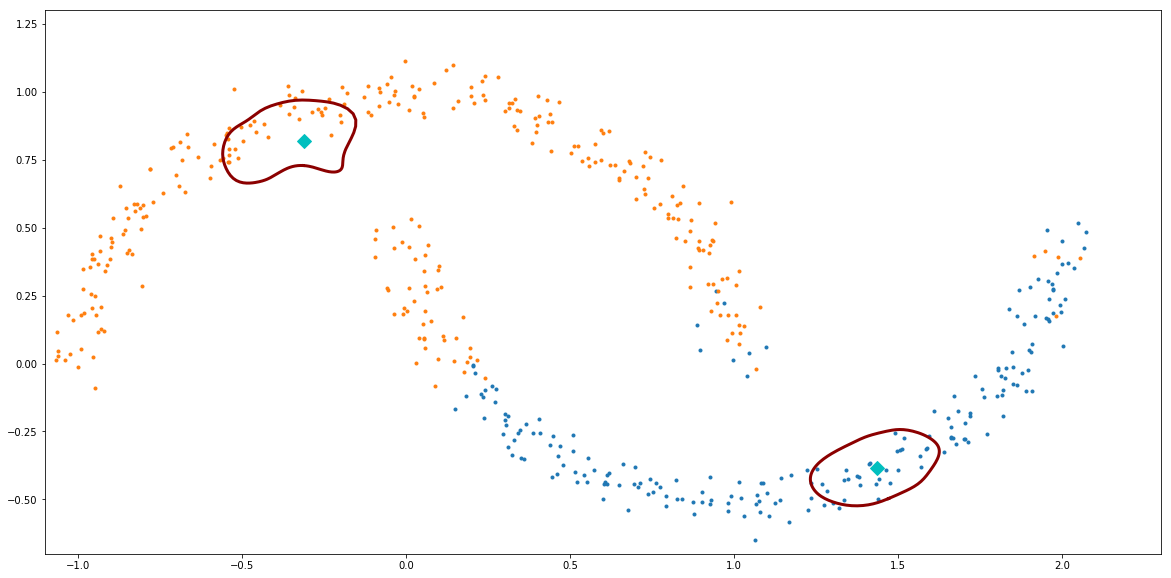

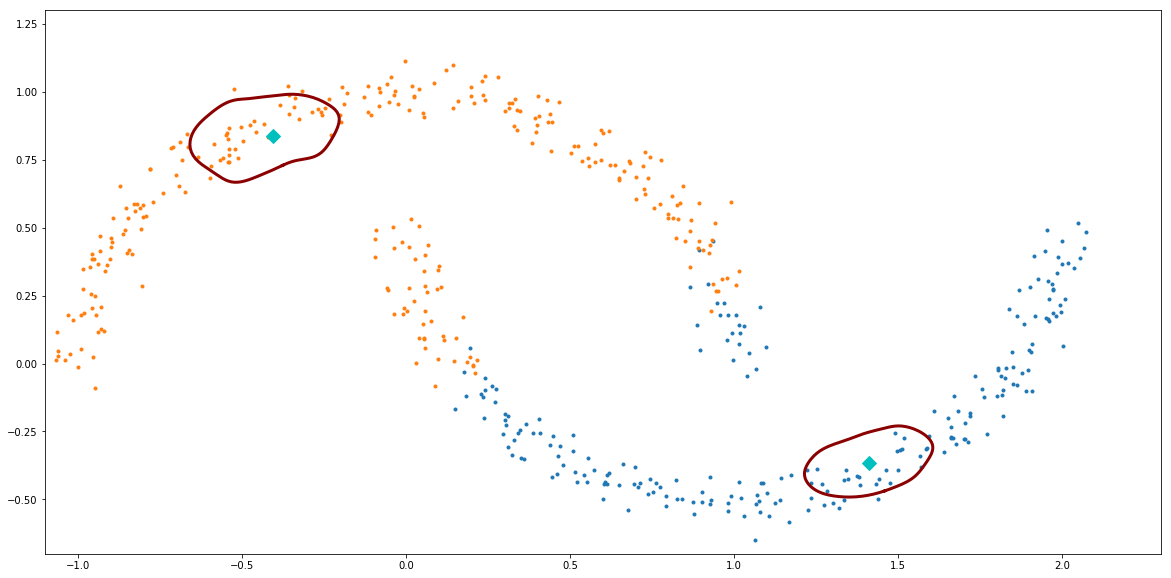

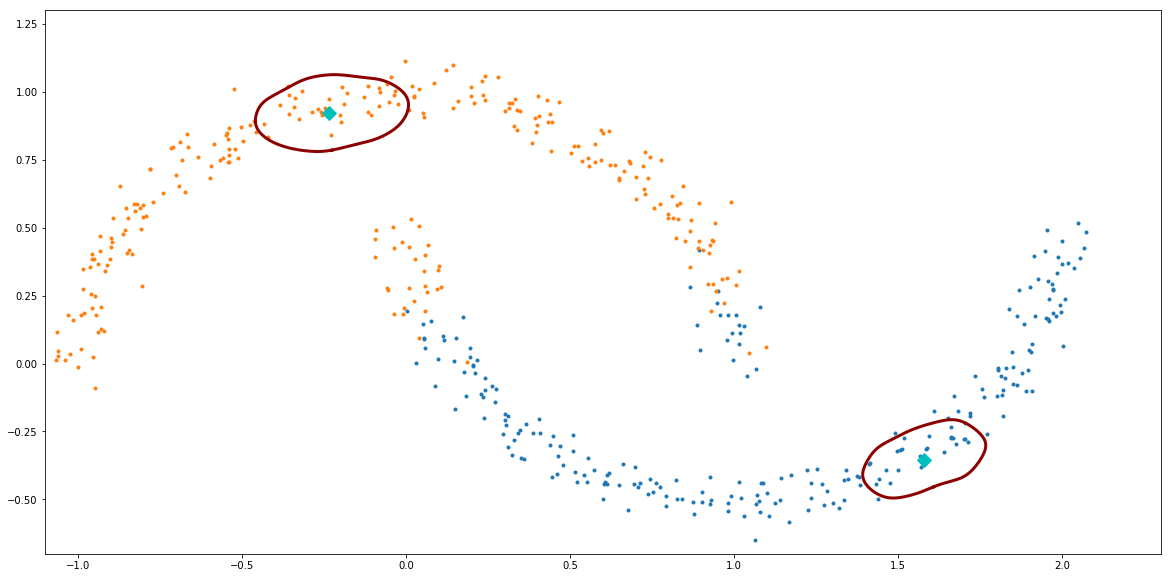

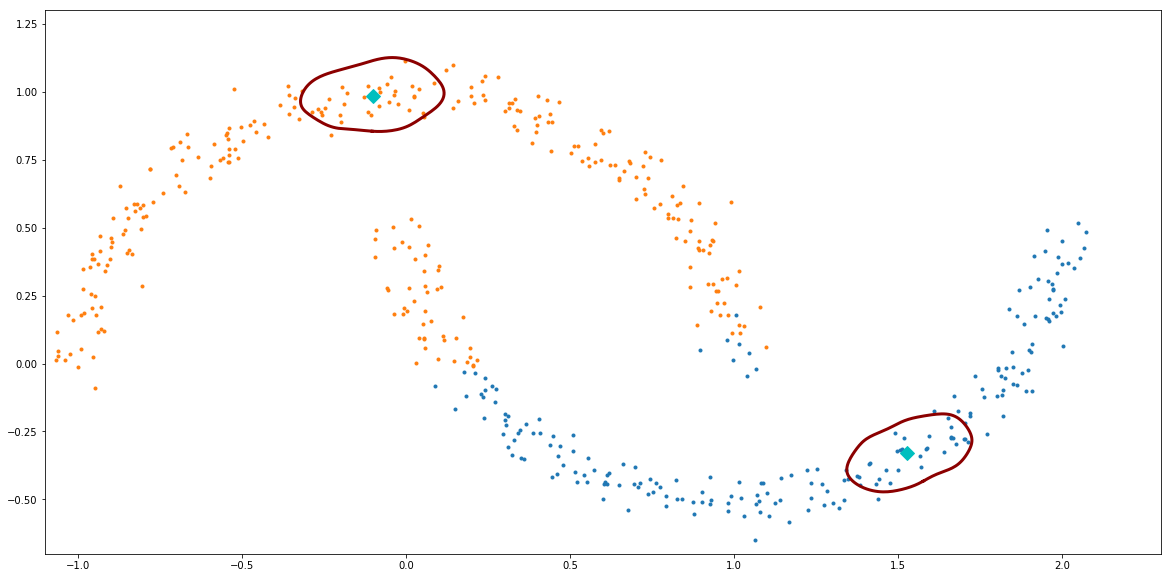

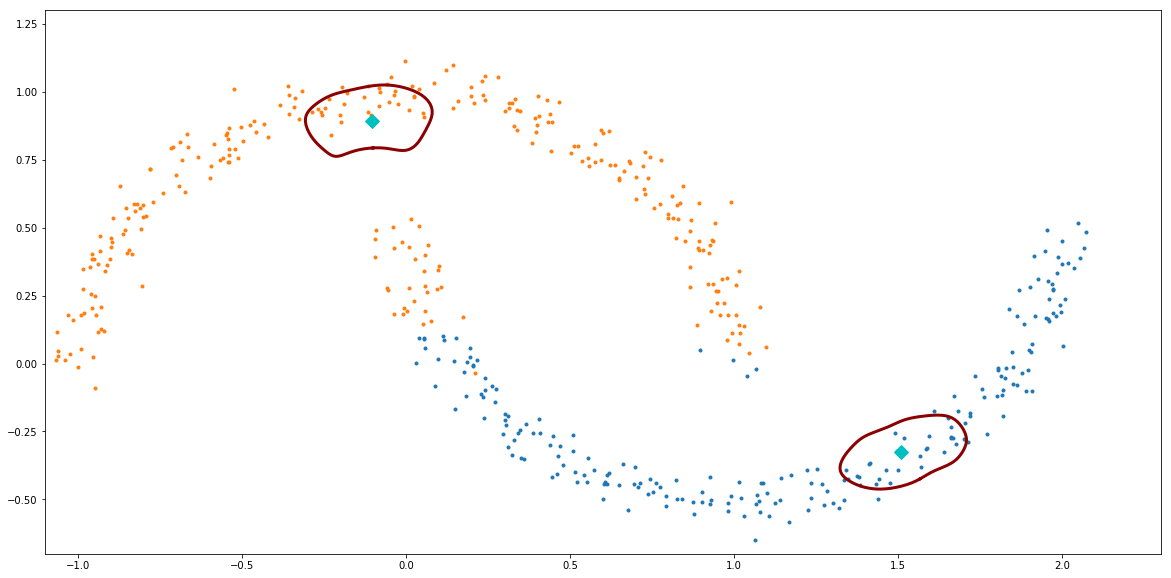

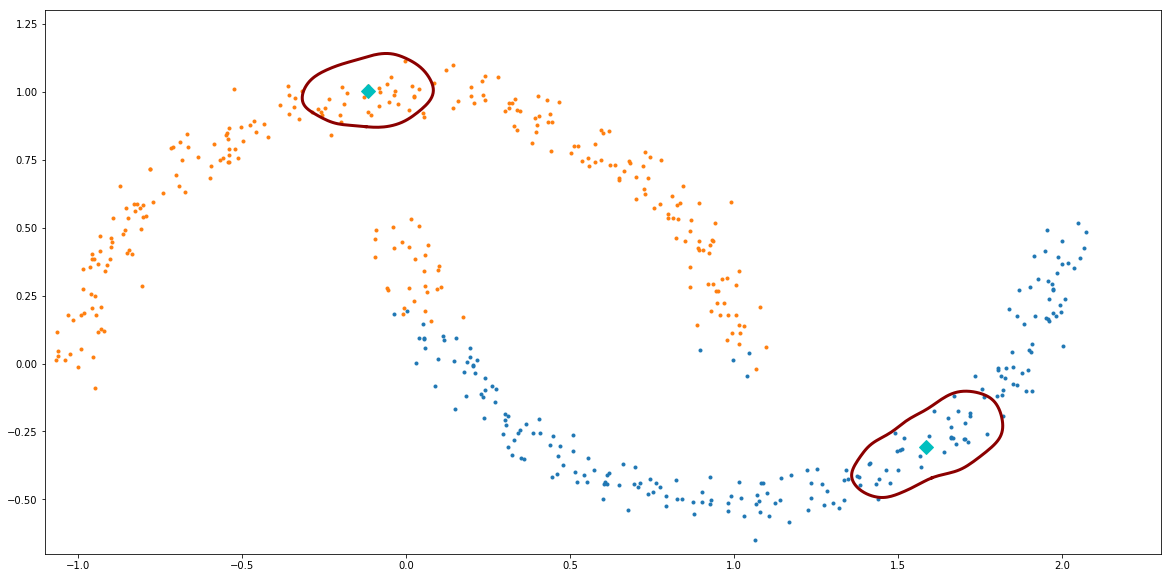

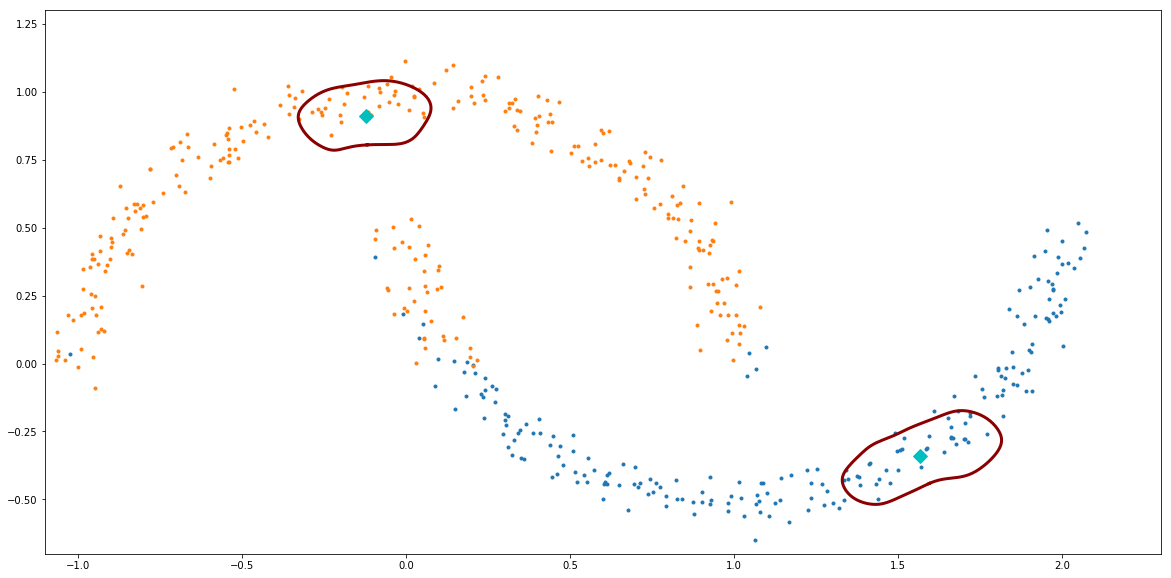

In [28]:
start = 18
end = 25


#load data
fp='results_mm/N500/'
ran = range(start,end)
C,Sigma,mu,respons=load_data(r=ran,fp=fp)
K=len(mu[0])


for i in range(start,end):
    print(i)
    X=[]
    for k in range(K):
          X.append(get_data_for_plot_normal_LAND(mu[i-start][k].reshape(2,1).detach(),Sigma[i-start][k].detach(),False,100))
          #X.append(get_data_for_plot_normal_LAND(mu[i-start][k].reshape(2,1).detach(),Sigma[i-start][k].detach(),True,[0.25,0.5,1,2,4,8],100))
    plot_normal_LAND([m.detach().numpy()[0] for m in mu[i-start]],X[:],K,respons[i-start],saveName='results_mm/N500_img/LAND_MM'+str(i))        



9
9
normal_Land: p=1
normal_Land: p=1


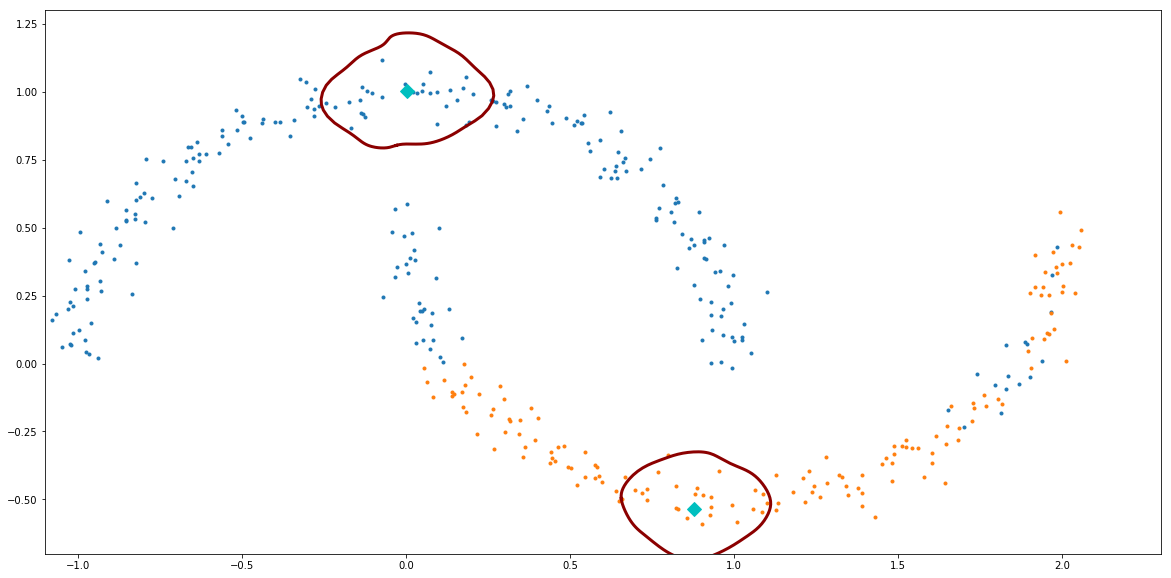

In [16]:
start = 9
end = 10


#load data
fp='results_mm/N400/'
ran = range(start,end)
C,Sigma,mu,respons=load_data(r=ran,fp=fp)
K=len(mu[0])


for i in range(start,end):
    print(i)
    X=[]
    for k in range(K):
          X.append(get_data_for_plot_normal_LAND(mu[i-start][k].reshape(2,1).detach(),Sigma[i-start][k].detach(),False,100))
          #X.append(get_data_for_plot_normal_LAND(mu[i-start][k].reshape(2,1).detach(),Sigma[i-start][k].detach(),True,[0.25,0.5,1,2,4,8],100))
    plot_normal_LAND([m.detach().numpy()[0] for m in mu[i-start]],X[:],K,respons[i-start],saveName='results_mm/N400_img/LAND_MM'+str(i))        



In [ ]:
start = 0
end = 3


#load data
fp='results_mm/new_C/'
ran = range(start,end)
C,Sigma,mu,respons=load_data(r=ran,fp=fp)
K=len(mu[0])

0
1
2


In [ ]:
Sigma = torch.eye(D)

In [ ]:
def calc_objective(mu, Sigma,respons, C=None, datasamples=200, S=1000):
    
    LL=0
    for k in range(K):
        responsSum = np.sum(respons[k])
        pi_k=responsSum/N
        for n in random.sample(range(0,N),datasamples):
            L1 = LogMap(mu[k],data[n])[0]
            L2 = torch.mv(torch.inverse(Sigma[k]), L1)
            
            LL += respons[k][n]*((torch.dot(L1,L2).detach()/2)+math.log(C[k])-math.log(pi_k))

        #if C is None:
        #    C = estimate_C(mu, Sigma, S)
   
        
    
  
    return LL

In [ ]:
#read objective from file
file_path = "results_mm/sigma_0.04_rho_0.3/objective.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
## read
bytes_in = bytearray(0)
input_size = os.path.getsize(file_path)
with open(file_path, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        bytes_in += f_in.read(max_bytes)
ob = pickle.loads(bytes_in)

In [ ]:
for i in range(13,63):
    ob.append(calc_objective(mu[i],Sigma[i],respons[i],C[i]))
    print('done '+str(i))
    saveObjective()
    gc.collect()
    

done 13
done 14
done 15
done 16
done 17
done 18
done 19
done 20
done 21
done 22
done 23
done 24
done 25
done 26
done 27
done 28
done 29
done 30
done 31
done 32
done 33
done 34
done 35


In [ ]:
import gc
gc.collect()

630

In [ ]:
def saveObjective():
    file_path = "results_mm/sigma_0.04_rho_0.3/objective.pkl"
    n_bytes = 2**31
    max_bytes = 2**31 - 1
    #data = bytearray(n_bytes)

    ## write
    bytes_out = pickle.dumps(ob)
    with open(file_path, 'wb') as f_out:
        for idx in range(0, len(bytes_out), max_bytes):
            f_out.write(bytes_out[idx:idx+max_bytes])
  #respons = np.zeros((K,N))

In [ ]:
f, axs = plt.subplots(1,1,figsize=(20,10));

plt.plot()

In [ ]:
ob

[tensor(929.9241),
 tensor(864.3823),
 tensor(866.5539),
 tensor(818.8414),
 tensor(718.1504),
 tensor(724.2941),
 tensor(762.1197),
 tensor(1486.2567),
 tensor(1539.0560),
 tensor(1445.9833),
 tensor(1411.5049),
 tensor(1458.7961)]

In [ ]:
import numpy as np
import random

class K_Means:
	def __init__(self, k=2, tol = 0.01):
		self.k = k
		self.tol = tol

	def fit(self,data):

		#Randomly select k points c_0,..., c_k−1 from S. These are the centers of the clusters.
		self.centroids = np.array([data[i] for i in random.sample(range(0, len(data)), self.k)])
		self.labels_ = np.zeros(len(data))

		C_old = np.zeros(self.centroids.shape)
		while 1:
			#For each xi ∈ S, assign xi to that cluster the center of which is closest.
			for i,x in enumerate(data):
				d = [np.linalg.norm(maha_distance(torch.tensor(x),torch.tensor(c))) for c in self.centroids] #distances
				self.labels_[i] = np.argmin(d)

			#deep copy of old values, otherwise its just a pointer
			C_old = np.copy(self.centroids)

			#Re-compute the centers cj to be the centroids of Cj.
			for i in range(self.k):
				points = [data[j] for j in range(len(data)) if self.labels_[j] == i]
				self.centroids[i] = np.mean(points, axis=0)

			error = np.linalg.norm(self.centroids - C_old, 1)
			if error <= self.tol:
				break


In [ ]:
def maha_distance(p,q,Sigma=torch.eye(2)):
    L1 = LogMap(p,q)[0]
    L2 = torch.mv(torch.inverse(Sigma), L1)
    return torch.dot(L1,L2).numpy()

In [ ]:
data[1]

tensor([ 1.2624, -0.4909])

In [ ]:
kmeans = K_Means(tol=0.001)

In [ ]:
kmeans.fit(data.numpy())


KeyboardInterrupt: ignored

In [ ]:
kmeans.labels_

array([0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
       0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0.,
       1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
       1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1.,
       1., 1., 1., 1., 0.

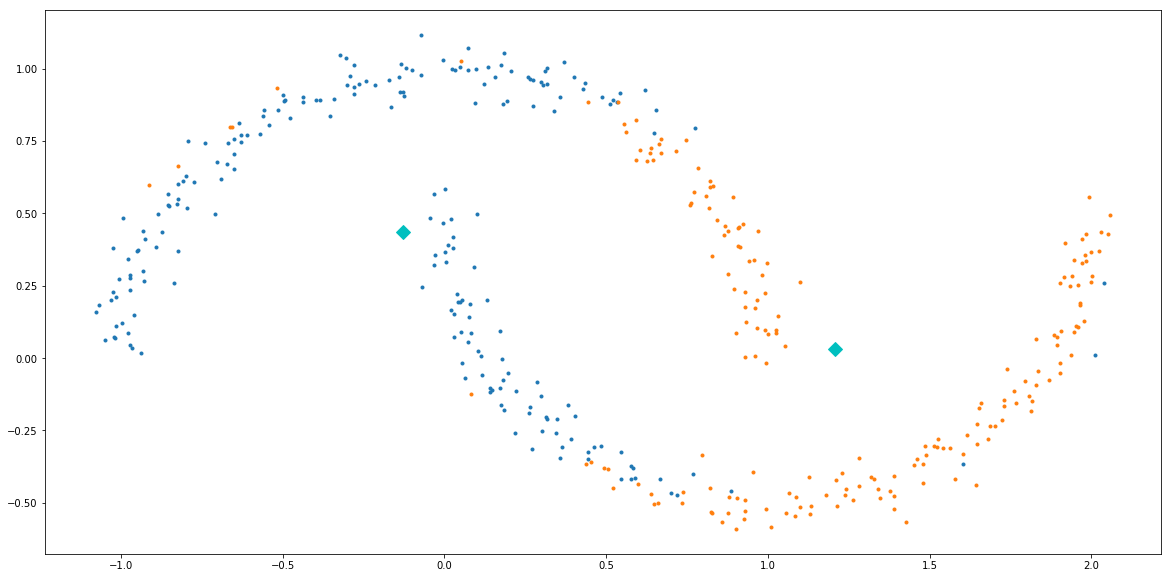

In [ ]:
    #f, axs = plt.subplots(1,1,figsize=(20,14));
    f, axs = plt.subplots(1,1,figsize=(20,10));
    K=2
    #Plot original data
    #plt.plot(data[:, 0].numpy(), data[:, 1].numpy(), '.',color='royalblue', markersize=7)
    #Plot original data with cluster responsibility
    cluster=[]
    for k in range(K):
        cluster.append(np.array([d.numpy() for i,d in enumerate(data) if kmeans.labels_[i]==k]))
        plt.plot(cluster[k][:, 0], cluster[k][:, 1], '.')
        plt.plot(kmeans.centroids[k][0], kmeans.centroids[k][1], 'cD', markersize = 10)
    #plt.plot(data[1,0].numpy(),data[1,1].numpy(),'rx',markersize=10)
    #plt.plot(data[2,0],data[2,1],'rx',markersize=10)
    #cluster2 = [d.numpy() for i,d in enumerate(data) if respons[0][i]<respons[1][i]]
    #print(cluster1)
    #if len(cluster1)>0:
    #    plt.plot(cluster1[:, 0].numpy(), cluster1[:, 1].numpy(), '.')
    #if len(cluster2)>0:
    #    plt.plot(cluster2[:, 0].numpy(), cluster2[:, 1].numpy(), '.')

    #Plot mu
    #for k in range(K):
    #    plt.plot(mu[k][0], mu[k][1], 'cD', markersize = 10)

In [ ]:
maha_distance(data[1],data[2])

In [ ]:
savepath="results_mm/kmeans/"

filehandler_1 = open(savepath+"labels_", 'wb')
filehandler_2 = open(savepath+'centroids_', 'wb') 
filehandler_3 = open(savepath+'kmeans', 'wb') 

pickle.dump(kmeans.labels_, filehandler_1)
pickle.dump(kmeans.centroids, filehandler_2)
pickle.dump(kmeans, filehandler_3)
filehandler_1.close()
filehandler_2.close()
filehandler_3.close()


In [ ]:
kmeans.centroids

In [ ]:
fp="results_mm/new_C/"
kmeans = pickle.load( open( fp+"kmeans", "rb" ) )


In [ ]:
kmeans.centroids

array([[-0.12898634,  0.43546987],
       [ 1.2068827 ,  0.03277878]], dtype=float32)

In [ ]:
len(cluster[1])

206

In [19]:
def calc_objective(mu, Sigma,respons, C=None, datasamples=200, S=1000):
    
    LL=0
    for k in range(K):
        responsSum = np.sum(respons[k])
        pi_k=responsSum/N
        for n in random.sample(range(0,N),datasamples):
            L1 = LogMap(mu[k],data[n])[0]
            L2 = torch.mv(torch.inverse(Sigma[k]), L1)
            
            LL += respons[k][n]*((torch.dot(L1,L2).detach()/2)+math.log(C[k])-math.log(pi_k))

         #if C is None:
        #    C = estimate_C(mu, Sigma, S)
   
        
    
  
    return LL

In [ ]:
#read objective from file
file_path = "results_mm/sigma_0.04_rho_0.3/objective.pkl"
n_bytes = 2**31
max_bytes = 2**31 - 1
## read
bytes_in = bytearray(0)
input_size = os.path.getsize(file_path)
with open(file_path, 'rb') as f_in:
    for _ in range(0, input_size, max_bytes):
        bytes_in += f_in.read(max_bytes)
ob = pickle.loads(bytes_in)